# Imports

In [301]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import jinja2
import dataframe_image as dfi

In [302]:
path = 'C:/Users/max05/OneDrive/Bureau/DATA/_Portfolio/GCC_project/data/raw/'
data = pd.read_csv(path+'HR_comma_sep.csv')
data.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Initial look 

In [303]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# Renaming columns

Some column names are capitalised, others arn't

In [304]:
df0 = data.rename(columns = {
    'time_spend_company':'years_spent_company',
    'Work_accident':'work_accident',
    'Department':'department'
})

# Missing values

In [305]:
df0.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
years_spent_company      0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no missing values in the dataset 

# Duplicates

In [306]:
print(f'{df0.duplicated().sum()} duplicated values in dataset')

3008 duplicated values in dataset


It seems highly unlikely that two employees would have the exact same scores on 11 different metrics.

We could investigate further but droping duplicates seems a reasonable course in this situation

In [307]:
df1 = df0.drop_duplicates(keep='first')
#Chack if duplicates were removed
df0.shape[0] - df1.shape[0]

3008

# Check for outliers 

In [308]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

<Axes: xlabel='last_evaluation'>

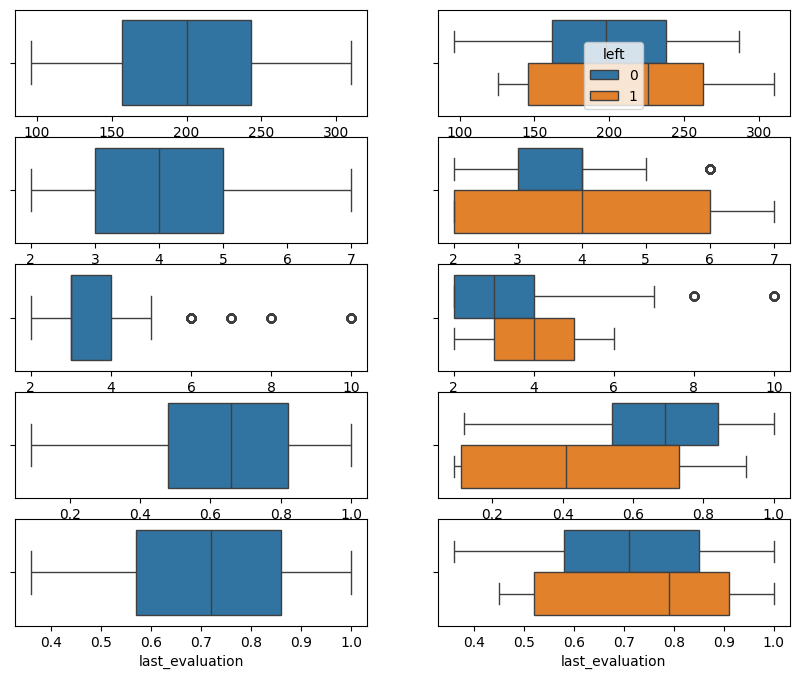

In [309]:
fig,ax = plt.subplots(5,2,figsize=(10,8))

#Boxplots of discrete and continuous variables 
sns.boxplot(data=df1,x='average_montly_hours',ax=ax[0,0])
sns.boxplot(data=df1,x='number_project',ax=ax[1,0])
sns.boxplot(data=df1,x='years_spent_company',ax=ax[2,0])
sns.boxplot(data=df1,x='satisfaction_level',ax=ax[3,0])
sns.boxplot(data=df1,x='last_evaluation',ax=ax[4,0])

# plots divided by departures 
sns.boxplot(data=df1,x='average_montly_hours',hue='left',ax=ax[0,1])
sns.boxplot(data=df1,x='number_project',hue='left',legend=None,ax=ax[1,1])
sns.boxplot(data=df1,x='years_spent_company',hue='left',legend=None,ax=ax[2,1])
sns.boxplot(data=df1,x='satisfaction_level',hue='left',legend=None,ax=ax[3,1])
sns.boxplot(data=df1,x='last_evaluation',hue='left',legend=None,ax=ax[4,1])



Most outliers are present in the years_spent_company metric, particularily in the stayed category.

There are allready some interesting paterns emerging in 'number_project','years_spent_company' and 'satisfaction_level' to be investigated later

In [310]:
#   Checking how many outliers are present in years_spent_company

upper_percentile = df1[['years_spent_company']].quantile(0.75).iloc[0]
lower_percentile = df1[['years_spent_company']].quantile(0.25).iloc[0]
iqr = upper_percentile-lower_percentile

outliers_df = df1[(df1['years_spent_company']>upper_percentile + 1.5*iqr) | (df1['years_spent_company']<lower_percentile - 1.5*iqr)]

print(f"{outliers_df.shape[0]} outliers in years_spent_company column wich is {(outliers_df.shape[0]/df1.shape[0]*100):.2f}% of the column")

824 outliers in years_spent_company column wich is 6.87% of the column


'years_spent_company' has 6.87% outliers in it. We will have to watch out when picking a model not to choose one sensitive to outliers

## Inspection of categorical metrics and of dimensions

## Correlation heatmap

<Axes: >

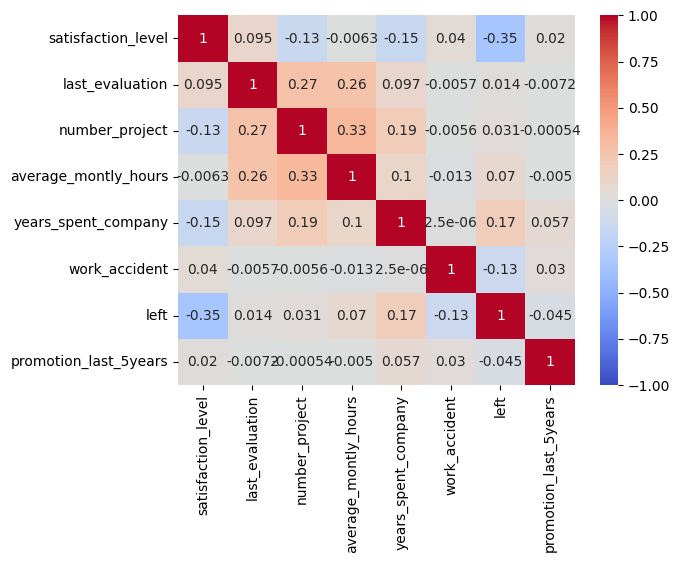

In [311]:
matrix = df1.corr(method='pearson',numeric_only=True)

sns.heatmap(matrix,vmin=-1,vmax=1,annot=True,cmap='coolwarm')

# Left column inspection

In [312]:
df1['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

# Work_accident column inspection

In [313]:
df1['work_accident'].value_counts(normalize=True)

work_accident
0    0.845718
1    0.154282
Name: proportion, dtype: float64

In [314]:
#   While we are at it, we might as well check the relation between work_accidents and departures
work_accident_df = (
    
    pd.DataFrame(
    df1[['work_accident','left']]
    .groupby(['work_accident'])
    .value_counts(normalize=False)
    .unstack()
    )
)

<Axes: xlabel='work_accident'>

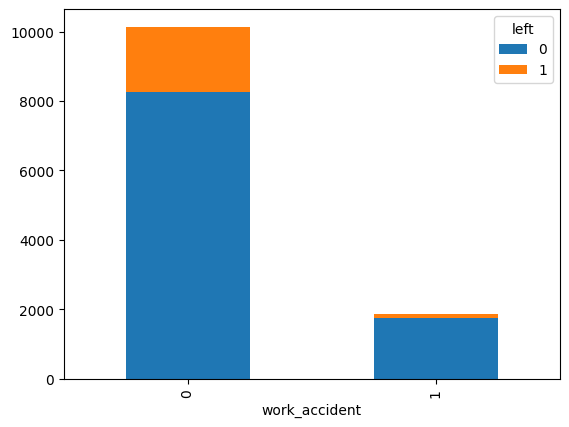

In [315]:
work_accident_df.plot.bar(stacked=True)

Based on this data, victims of a work accident do not seem more likely to leave.

<Axes: xlabel='average_montly_hours', ylabel='Count'>

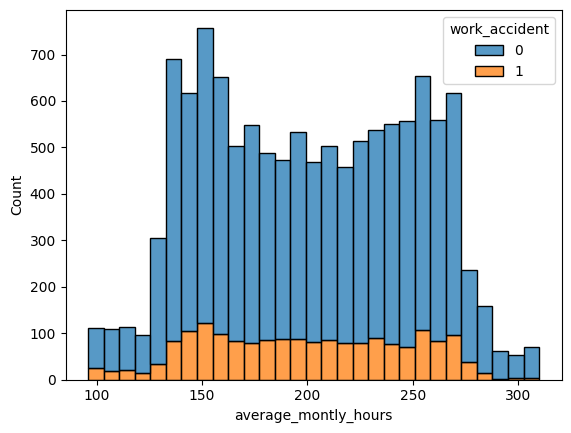

In [316]:
sns.histplot(df1,x='average_montly_hours',hue='work_accident',multiple='stack')

In [317]:
work_bins = [0,50,100,150,200,250,300]

accident_by_hours_worked_df = (
    df1.groupby([pd.cut(df1['average_montly_hours'],work_bins),'work_accident'])
    .size()
    .unstack()
)

accident_by_hours_worked_df['percent_of_accident'] = accident_by_hours_worked_df[1]*100 / (accident_by_hours_worked_df[0] + accident_by_hours_worked_df[1])
accident_by_hours_worked_df['total_of_workers'] = (accident_by_hours_worked_df[0] + accident_by_hours_worked_df[1])

(
    accident_by_hours_worked_df[['total_of_workers','percent_of_accident']]
    .fillna(0)
    .sort_values(by='percent_of_accident',ascending=False)
    .head(5)
)

C:\Users\max05\AppData\Local\Temp\ipykernel_27580\1167378915.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['average_montly_hours'],work_bins),'work_accident'])


work_accident,total_of_workers,percent_of_accident
average_montly_hours,,
"(50, 100]",67,23.880597
"(150, 200]",3717,16.411084
"(200, 250]",3536,15.639140
"(250, 300]",2318,14.797239
"(100, 150]",2261,14.329943


In [318]:
df1.groupby(['number_project'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).rename(columns={1:'Percent of work accident'})

work_accident,Percent of work accident
number_project,
2,0.111252
3,0.175852
4,0.160651
5,0.156740
6,0.134383
7,0.013793


In [319]:
df1.groupby(['years_spent_company'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).rename(columns={1:'Percent of work accident'})

work_accident,Percent of work accident
years_spent_company,
2,0.171821
3,0.149711
4,0.137656
5,0.140301
6,0.162362
7,0.138298
8,0.271605
10,0.233645


In [320]:
df1.groupby(['department'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).sort_values(by=1,ascending=False).rename(columns={1:'Percent of work accident'})

work_accident,Percent of work accident
department,
RandD,0.171470
management,0.165138
support,0.164195
marketing,0.160475
product_mng,0.158892
sales,0.153751
technical,0.151070
IT,0.142418
accounting,0.140097


Analysis does not reveal a clear correlation between work accidents and other relevant metrics.

# 'Promotion_last_5years' column inspection

In [321]:
df1['promotion_last_5years'].value_counts(normalize=True)

promotion_last_5years
0    0.983071
1    0.016929
Name: proportion, dtype: float64

In [322]:
promotion_df = (
    
    pd.DataFrame(
    df1[['promotion_last_5years','left']]
    .groupby('promotion_last_5years')
    .value_counts()
    .unstack()
    )
)

<Axes: xlabel='promotion_last_5years'>

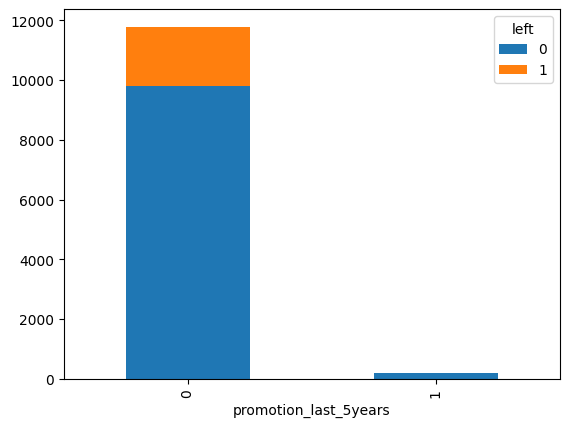

In [323]:
promotion_df.plot.bar(stacked=True)

In [324]:
promotion_df['percent_left'] = promotion_df[1] / (promotion_df[0]+promotion_df[1])
promotion_df

left,0,1,percent_left
promotion_last_5years,,,
0,9805,1983,0.168222
1,195,8,0.039409


Based on data, employees that did not get a raise in the last 5 years seem to be much more likely to leave. Further investigation could be beneficial. Also, there doesn't seem to be a lot of promoting in Saliford Motors. Creating new echelons could bring a sense of progression to keep engagement high.

In [325]:
bins = [0,0.2,0.4,0.6,0.8,1]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['last_evaluation'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_27580\3382442588.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['last_evaluation'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
last_evaluation,,,
"(0.0, 0.2]",0,0,NaN
"(0.2, 0.4]",8,201,3.980100
"(0.4, 0.6]",56,3622,1.546107
"(0.6, 0.8]",77,3883,1.983003
"(0.8, 1.0]",62,4285,1.446908


In [326]:
bins = [0,0.2,0.4,0.6,0.8,1]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['satisfaction_level'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_27580\2426002478.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['satisfaction_level'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
satisfaction_level,,,
"(0.0, 0.2]",8,994,0.804829
"(0.2, 0.4]",13,1184,1.097973
"(0.4, 0.6]",58,2872,2.019499
"(0.6, 0.8]",64,3599,1.778272
"(0.8, 1.0]",60,3342,1.795332


From further inspection, promotions do not appear to be related to employees last evaluation. It could be worth investigating why that is the case.

In [327]:
(
    df1.groupby(['number_project'])
        ['promotion_last_5years']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .sort_values(by=1,ascending=False)
        .drop(columns=[0])
        .rename(columns={1:'percent_of_promotion_given'})
)

promotion_last_5years,percent_of_promotion_given
number_project,
4,0.020624
3,0.017614
6,0.015738
5,0.014778
2,0.012010
7,0.000000


In [328]:
bins = [100,150,200,250,300]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['average_montly_hours'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_27580\1237378970.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['average_montly_hours'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
average_montly_hours,,,
"(100, 150]",44,2261,1.946042
"(150, 200]",57,3717,1.533495
"(200, 250]",65,3536,1.838235
"(250, 300]",36,2318,1.553063


    The number of promotions do not appear related to the number of hours worked, the number of project participated in nor to the last evaluation of the worker.

    They do however, appear to be correlated to their satisfaction levels.

# 'Salary' column inspection

In [329]:
salary_proportion = pd.DataFrame(df1['salary'].value_counts(normalize=True))
salary_proportion

,proportion
salary,
low,0.478692
medium,0.438746
high,0.082562


In [330]:
salary_df = (
    pd.DataFrame(
    df1[['salary','left']]
    .groupby('salary')
    .value_counts()
    .unstack()
    )
)

<Axes: xlabel='salary'>

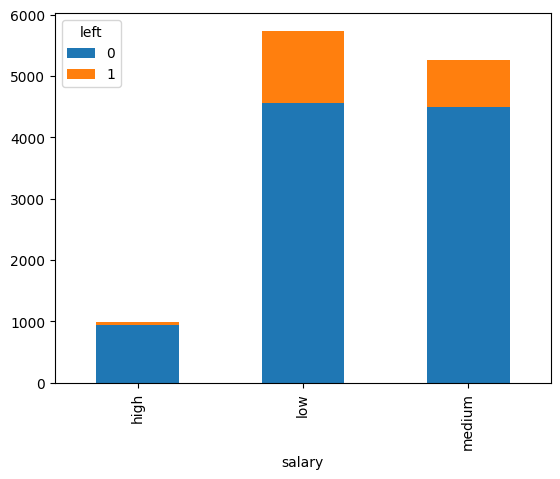

In [331]:
salary_df.plot.bar(stacked=True)

    We can see from the data that higher paid staff are more likely to stay.

# 'Department' column inspection

In [332]:
department_proportion = pd.DataFrame(df1['department'].value_counts(normalize=True).round(2))

In [333]:
department_df = (
    pd.DataFrame(
    df1[['department','left']]
    .groupby('department')
    .value_counts()
    .unstack()
    )
)
department_df['percent_left'] = round(department_df[1] / (department_df[0]+department_df[1]),2)
department_df = department_df.sort_values(by='percent_left',ascending=False)
department_df[['percent_left']].join(department_proportion).rename(columns={'proportion':'proportion_of_company_staff'})

,percent_left,proportion_of_company_staff
department,,
hr,0.19,0.05
accounting,0.18,0.05
technical,0.17,0.19
support,0.17,0.15
marketing,0.17,0.06
sales,0.17,0.27
product_mng,0.16,0.06
IT,0.16,0.08
RandD,0.12,0.06


C:\Users\max05\AppData\Local\Temp\ipykernel_27580\1811665518.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=department_df,x='percent_left',y='department',palette=cols)


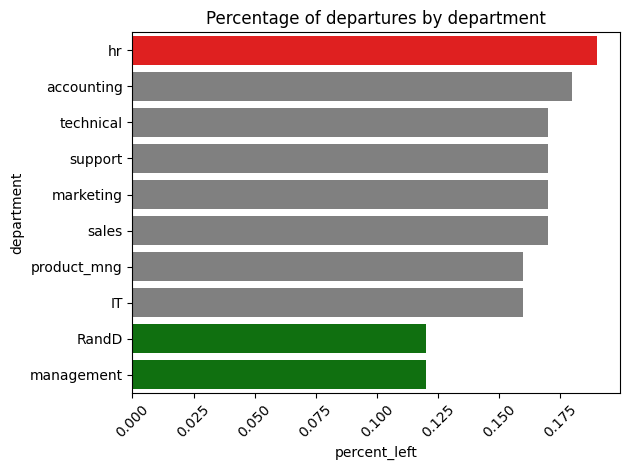

In [334]:
cols = ['red' if x>0.18 else 'green' if x<0.13 else 'grey' for x in department_df.percent_left]

sns.barplot(data=department_df,x='percent_left',y='department',palette=cols)

plt.xticks(rotation=45)
plt.title('Percentage of departures by department')

plt.tight_layout()
plt.savefig('../reports/figures/departure_by_department.png')

3 departements stand out regarding tenure,

    HR has the most with 19%
    RandD and Management have the least with around 12%

In [335]:
salary_by_department_df = df1.groupby(by=['department','salary']).size().unstack()

salary_by_department_df['count'] = salary_by_department_df['high'] + salary_by_department_df['low'] + salary_by_department_df['medium']
salary_by_department_df['high_perc'] = salary_by_department_df['high']*100/salary_by_department_df['count']
salary_by_department_df['medium_perc'] = salary_by_department_df['medium']*100/salary_by_department_df['count']
salary_by_department_df['low_perc'] = salary_by_department_df['low']*100/salary_by_department_df['count']

(
salary_by_department_df
    .sort_values(by=['high_perc'],ascending=True)
    .drop(['count','high','medium','low'],axis=1)
    .style
    #.bar()
    .background_gradient(cmap='Blues',axis=0)
)

salary,high_perc,medium_perc,low_perc
department,,,
hr,6.322795,44.425957,49.251248
RandD,6.772334,46.829971,46.397695
support,6.919275,45.469522,47.611203
IT,7.274590,43.954918,48.770492
sales,7.317073,44.736030,47.946897
technical,7.397504,41.889483,50.713012
product_mng,7.580175,42.419825,50.000000
marketing,9.212481,44.725111,46.062407
accounting,10.144928,42.190016,47.665056


# Inspection of other metrics

## Inspection of 'satisfaction_level' column

In [336]:
df1.satisfaction_level.describe()

count    11991.000000
mean         0.629658
std          0.241070
min          0.090000
25%          0.480000
50%          0.660000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

<Axes: xlabel='satisfaction_level', ylabel='Count'>

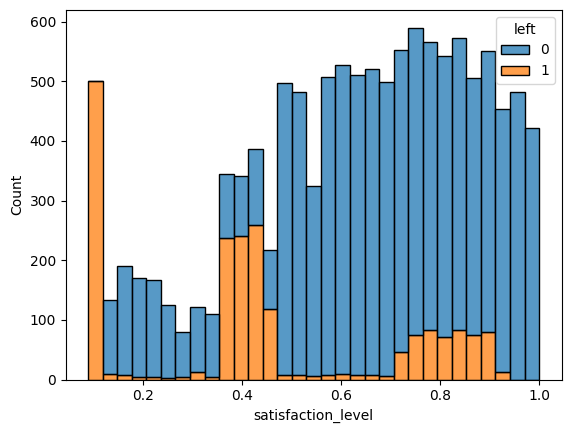

In [337]:
sns.histplot(data=df1,x='satisfaction_level',hue='left',multiple='stack')

Population seems highly polarised with a group normalised around 70% and a smaller group normalised around 20%. Most of the departures occur in three separate groups. One of them is not satisfied at all, one other is about 40% satisfied and another is pretty satisfied being around 80%.

In [338]:
table_satisfaction_by_year = (
    df1[['satisfaction_level','years_spent_company']]
    .groupby(by='years_spent_company').mean()
    #.sort_values(by='satisfaction_level',ascending=False)
)

table_satisfaction_by_year = table_satisfaction_by_year.rename(columns={'satisfaction_level':'Average Satisfaction'})
table_satisfaction_by_year.index.name = 'Years'
table_satisfaction_by_year = (table_satisfaction_by_year
                              .style
                              #.bar()
                              .background_gradient(cmap='Blues',axis=0)
                              )

table_satisfaction_by_year

,Average Satisfaction
Years,
2,0.699165
3,0.648988
4,0.516090
5,0.583183
6,0.571107
7,0.635957
8,0.665062
10,0.655327


In [339]:
dfi.export(table_satisfaction_by_year,'../reports/figures/table_satisfaction_by_year.png')

In [340]:
df1['satisfaction_level'].describe()

count    11991.000000
mean         0.629658
std          0.241070
min          0.090000
25%          0.480000
50%          0.660000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [341]:
# Defining a breakpoint of 75% as being satisfied with the work environnement, we can look at how many employees fall into the category
satisfied_df = (df1[df1['satisfaction_level']>=0.75])

satisfied_df.shape[0]/df1.shape[0]

0.3726961888082729

- We can see from the satisfaction statistics that satisfaction is mostly positive with a median of 66%

- About 37% of the employees surveyed report being above 75% satisfied wich could probably be improved

In [342]:
# we can compare descriptive stats of "statisfied" employees with the whole population
(
pd.DataFrame(satisfied_df.describe()-df1.describe())
.drop(['satisfaction_level'],axis=1)
.style
.hide(subset=['count','std','25%','75%'],axis=0)
)

,last_evaluation,number_project,average_montly_hours,years_spent_company,work_accident,left,promotion_last_5years
mean,0.029818,0.052149,5.374319,-0.041071,0.006604,-0.065348,0.001867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.040000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,-1.000000,-3.000000,0.000000,0.000000,0.000000,0.000000


Comparing high satisfaction statistics with the whole population reports that:

- The mean of their last evaluation is about 3% higher and they work on average 5.37 more hours monthly
- The average of their number of project is higher while the maximum of project is one less

# Inspection of 'last_evaluation' column

In [343]:
df1['last_evaluation'].describe()

count    11991.000000
mean         0.716683
std          0.168343
min          0.360000
25%          0.570000
50%          0.720000
75%          0.860000
max          1.000000
Name: last_evaluation, dtype: float64

(0.0, 1.0319999999999998)

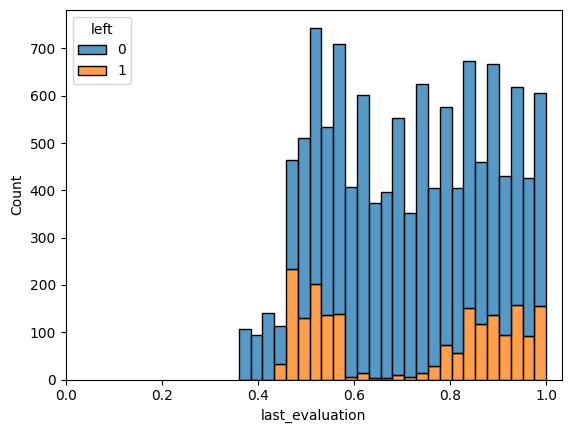

In [344]:
sns.histplot(data=df1,x='last_evaluation',hue='left',multiple='stack')
plt.xlim(left=0)

Two distinct groups are evident in departures, a group of low performers that might have been fired and a group of high performers that could have gone for a higher paying job.

# Inspection of 'number_project' column

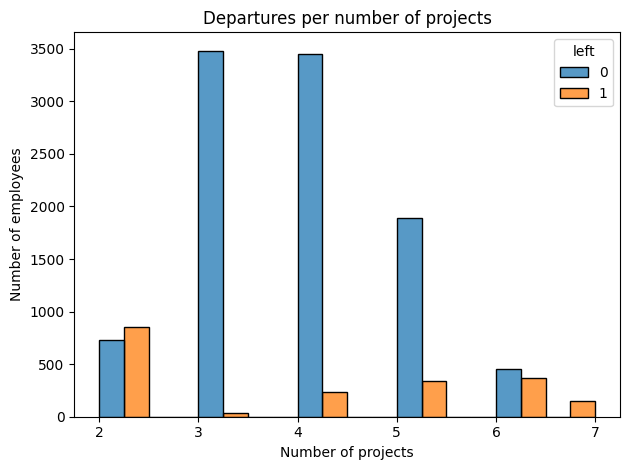

In [345]:
sns.histplot(data=df1,x='number_project',hue='left',multiple='dodge',binwidth=0.5)

plt.title('Departures per number of projects')
plt.xlabel('Number of projects')
plt.ylabel('Number of employees')

plt.tight_layout()
plt.savefig('../reports/figures/leave_per_number_project.png') 

<Axes: xlabel='number_project', ylabel='satisfaction_level'>

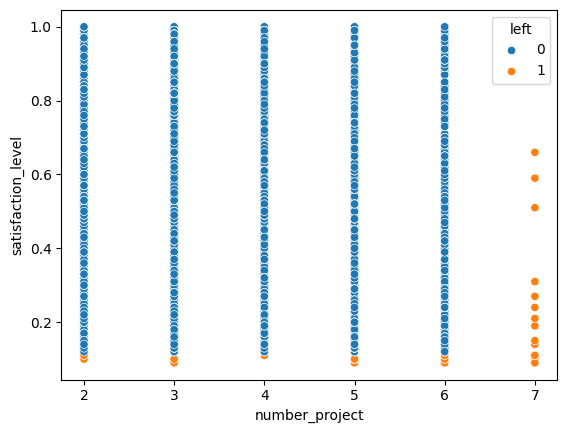

In [346]:
sns.scatterplot(data=df1,y='satisfaction_level',x='number_project',hue='left')

In [347]:
number_project_df = (
    pd.DataFrame(
    df1[['number_project','left']]
    .groupby('number_project')
    .value_counts()
    .unstack()
    .fillna(0)
    )
)

In [348]:
number_project_df['percent_left'] = number_project_df[1]*100/(number_project_df[0]+number_project_df[1])
number_project_df['count'] = number_project_df[1] + number_project_df[0]

In [349]:
table_num_project = (
    round(number_project_df[['count','percent_left']],0)
    .sort_values(by='percent_left',ascending=True)
    .rename(columns={'count':'Count','percent_left':'Percent','number_project':'Project Number'})
)
table_num_project.index.name = 'Project Number'
table_num_project.style
table_num_project

left,Count,Percent
Project Number,,
3,3520.0,1.0
4,3685.0,6.0
5,2233.0,15.0
6,826.0,45.0
2,1582.0,54.0
7,145.0,100.0


In [350]:
dfi.export(table_num_project,'../reports/figures/table_departure_per_years.png')

    The totality of 145 workers with 7 projects assigned left the company regardless of their satisfaction levels. Assigning a maximum of 6 projects per employee might help with retention.

    Furthermore, keeping the number of projects assigned between 3 and 5 seems to be preferable for retention.

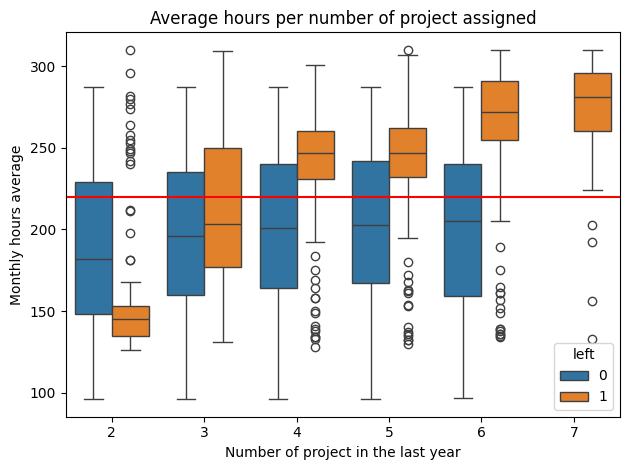

In [351]:
sns.boxplot(data=df1,x='number_project',y='average_montly_hours',hue='left')

plt.axhline(y=220,color='red')
plt.title('Average hours per number of project assigned')
plt.xlabel('Number of project in the last year')
plt.ylabel('Monthly hours average')

plt.tight_layout()
plt.savefig('../reports/figures/monthly_hours_per_project.png') 

Looking further in the data we can see that even at high project count, departures seem to mostly occur when matched with high working hours. 

High project count with medium working hours do not seem to be associated with departure.

# Inspection of 'average_montly_hours' column

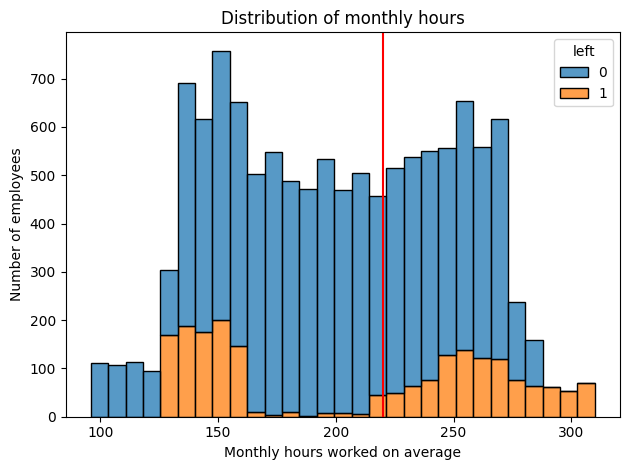

In [352]:
sns.histplot(data=df1,x='average_montly_hours',hue='left',multiple='stack')

plt.axvline(x=220,color='red')
plt.title('Distribution of monthly hours')
plt.xlabel('Monthly hours worked on average')
plt.ylabel('Number of employees')

plt.tight_layout()
plt.savefig('../reports/figures/distribution_of_monthly_hours_average.png') 

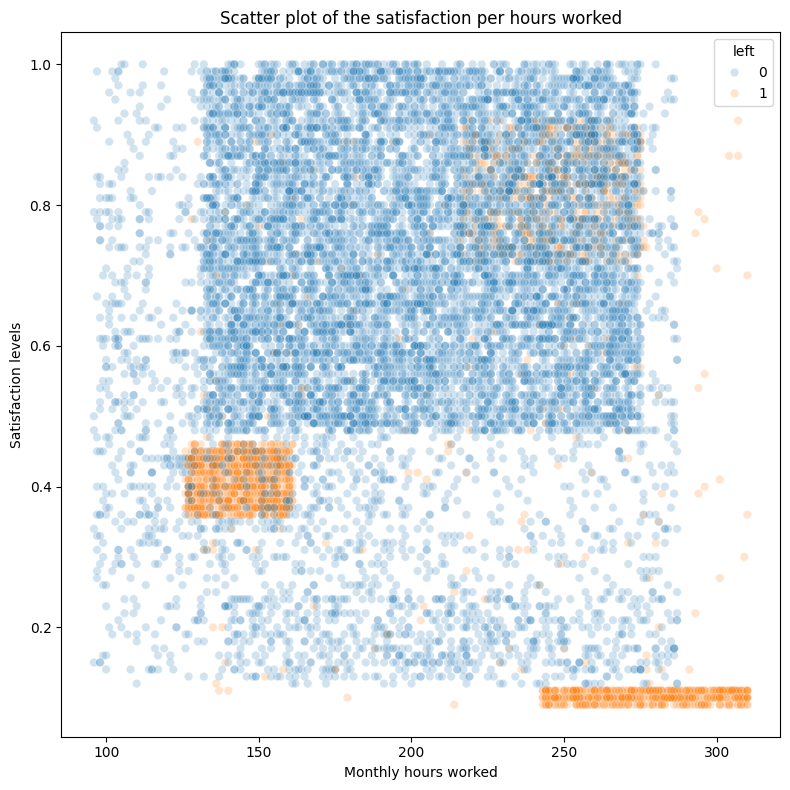

In [353]:
plt.figure(figsize=(8,8))

sns.scatterplot(data=df1,x='average_montly_hours',y='satisfaction_level',hue='left',alpha=0.2)

plt.title('Scatter plot of the satisfaction per hours worked')
plt.xlabel('Monthly hours worked')
plt.ylabel('Satisfaction levels')

plt.tight_layout()
plt.savefig('../reports/figures/scatter_plot_satisfaction_vs_hours.png') 

3 areas can be identified on the scatter plot:
- High work hours, low satisfaction: Most likely left from burn out
- High work hours, high satisfaction: Most likely left for higher paid job
- Low work hours, low satisfaction: Most likely fired for low performance

# Inspection of 'years_spent_company' column

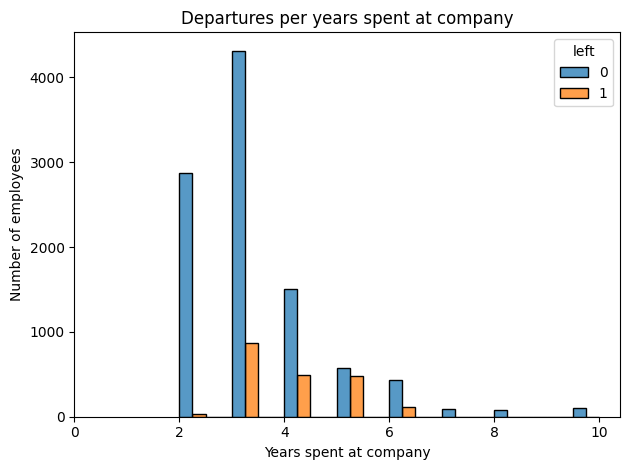

In [354]:
sns.histplot(data=df1,x='years_spent_company',hue='left',multiple='dodge',binwidth=0.5)

plt.title('Departures per years spent at company')
plt.xlabel('Years spent at company')
plt.ylabel('Number of employees')
plt.xlim(left=0)

plt.tight_layout()
plt.savefig('../reports/figures/leave_per_years_at_company.png') 

In [355]:
table_departures_per_year = (
    df1[['years_spent_company','left']]
    .groupby(by='years_spent_company').value_counts(normalize=True)
    .unstack()
    [[1]]
    .rename(columns={1:'Percent of departures'})
    .round(2)
    .fillna(0)
    .style
    #.background_gradient()
)

table_departures_per_year.bar()


left,Percent of departures
years_spent_company,
2,0.010000
3,0.170000
4,0.250000
5,0.450000
6,0.200000
7,0.000000
8,0.000000
10,0.000000


In [356]:
satisfaction_by_year_df = (
    pd.DataFrame(
        df1.groupby(['years_spent_company','left'])['satisfaction_level'].mean())
        .unstack()
)
satisfaction_by_year_df.style.bar()

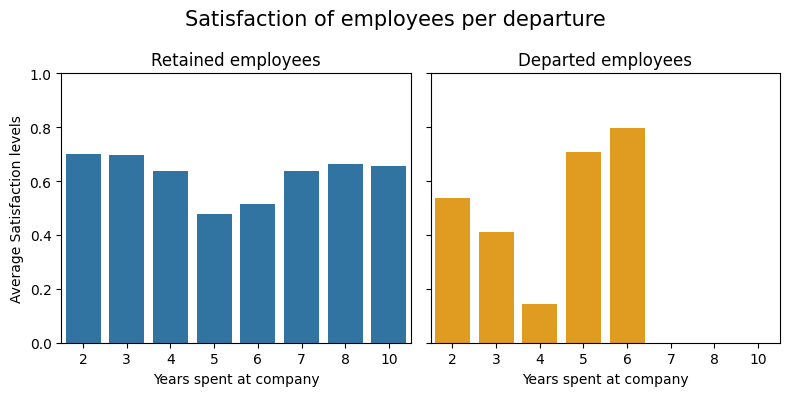

In [357]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
fig.suptitle('Satisfaction of employees per departure',fontsize=15)

sns.barplot(satisfaction_by_year_df['satisfaction_level'][0],ax=ax[0])

ax[0].set_title('Retained employees')
ax[0].set_ylim(top=1)
ax[0].set_ylabel('Average Satisfaction levels')
ax[0].set_xlabel('Years spent at company')

sns.barplot(satisfaction_by_year_df['satisfaction_level'][1],ax=ax[1],color='orange')

ax[1].set_title('Departed employees')
ax[1].set_ylim(top=1)
ax[1].set_xlabel('Years spent at company')

plt.tight_layout()
plt.savefig('../reports/figures/satisfaction_per_years_at_company.png') 

The 4 to 6 year mark seems to contribute a piece to the puzzle.

- retained personnel looks to be droping satisfaction in those 3 years
- The opposite is true for departed personnel in the years 5 and 6

In [358]:
promoted_df = df1[df1['promotion_last_5years']==1]
non_promoted_df = df1[df1['promotion_last_5years']==0]

In [359]:
pd.DataFrame(promoted_df.groupby(['years_spent_company','left'])
             ['satisfaction_level']
             .count()
             ).unstack().rename(columns={'satisfaction_level':'Count of leave for promoted personnel'})

Count of leave for promoted personnel     
left                                                    0    1
years_spent_company                                           
2                                                    39.0  NaN
3                                                    83.0  6.0
4                                                    21.0  1.0
5                                                    10.0  1.0
6                                                    11.0  NaN
7                                                    18.0  NaN
8                                                     5.0  NaN
10                                                    8.0  NaN

In [360]:
pd.DataFrame(non_promoted_df.groupby(['years_spent_company','left'])
             ['satisfaction_level']
             .count()
             ).unstack().rename(columns={'satisfaction_level':'Count of leave for non-promoted personnel'})

Count of leave for non-promoted personnel       
left                                                        0      1
years_spent_company                                                 
2                                                      2840.0   31.0
3                                                      4233.0  868.0
4                                                      1489.0  494.0
5                                                       570.0  481.0
6                                                       422.0  109.0
7                                                        76.0    NaN
8                                                        76.0    NaN
10                                                       99.0    NaN

There is a definite increase in leave as the number of year without promotion increases in the company

In [361]:
# We might see this relation clearer in percentage
non_promoted_departure_proportion = pd.DataFrame(non_promoted_df.groupby(['years_spent_company','left'])
             ['satisfaction_level']
             .count()
             ).unstack()
non_promoted_percent_of_leave = pd.DataFrame(non_promoted_departure_proportion['satisfaction_level'][1]/(non_promoted_departure_proportion['satisfaction_level'][0]+non_promoted_departure_proportion['satisfaction_level'][1])).rename(columns={0:'percent of departure for non-promoted personel'})

promoted_departure_proportion = pd.DataFrame(promoted_df.groupby(['years_spent_company','left'])
             ['satisfaction_level']
             .count()
             ).unstack()
promoted_percent_of_leave = pd.DataFrame(promoted_departure_proportion['satisfaction_level'][1]/(promoted_departure_proportion['satisfaction_level'][0]+promoted_departure_proportion['satisfaction_level'][1])).rename(columns={0:'percent of departure for promoted personel'})

non_promoted_percent_of_leave

,percent of departure for non-promoted personel
years_spent_company,
2,0.010798
3,0.170163
4,0.249117
5,0.457659
6,0.205273
7,NaN
8,NaN
10,NaN


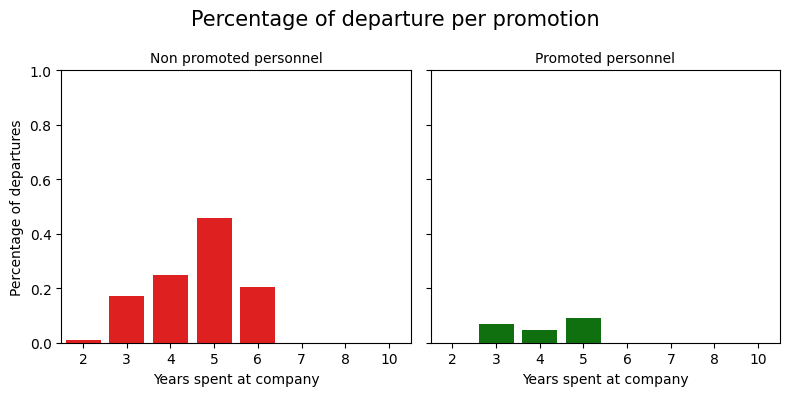

In [362]:
fig2, ax2 = plt.subplots(1,2,figsize=(8,4),sharey=True)
fig2.suptitle('Percentage of departure per promotion',fontsize=15)

sns.barplot(non_promoted_percent_of_leave, x='years_spent_company',y='percent of departure for non-promoted personel',ax=ax2[0],color='red')
sns.barplot(promoted_percent_of_leave, x='years_spent_company',y='percent of departure for promoted personel',ax=ax2[1],color='green')

ax2[0].set_title('Non promoted personnel',fontsize=10)
ax2[0].set_xlabel('Years spent at company')
ax2[0].set_ylabel('Percentage of departures')
ax2[0].set_ylim(top=1)

ax2[1].set_title('Promoted personnel',fontsize=10)
ax2[1].set_xlabel('Years spent at company')
ax2[1].set_ylim(top=1)

plt.tight_layout()
plt.savefig('../reports/figures/years_spent_company_per_promotion.png') 

In [363]:
df1.to_csv(path[:-4]+'interim/HR_cleaned_dataset.csv')